In [14]:
# load libraries 

# basic libraries
import numpy as np
import pandas as pd
import os
import glob
import copy

# mne-python 
import mne 

# fooof 
from fooof import FOOOF, fit_fooof_3d, FOOOFGroup
from fooof.analysis import get_band_peak_fg, get_band_peak_fm
from fooof.bands import Bands

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# stats
import scipy.stats as stats
import scipy.integrate


# Load EEG Data
- load group list/deid log
- get list of files and join with deid log

In [123]:
# set wd
working_dir = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/bb_fooof/'
data_dir = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/new_BBLong_even_paradigm/'
data_dir_old = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/'
os.chdir(working_dir)

# get deid log
deid_log = pd.read_csv("./bblong_group_list.csv")
deid_log.columns = ["eegid", "group"]
deid_log["eegid"] = deid_log["eegid"].astype(int)


# get list of files 
file_list = glob.glob(data_dir + '*.set')
file_list.sort()

# join file list with group list to get final file list 
df_tmp = pd.DataFrame(file_list, columns = ['file_path'])
df_tmp['eegid'] = [os.path.basename(path)[0:4] for path in df_tmp['file_path']]
df_tmp['eegid'] = df_tmp['eegid'].astype(int)
df_filelist = deid_log.merge(df_tmp, on='eegid', how='left')
df_filelist = df_filelist.dropna()
df_filelist



,eegid,group,file_path
0,228,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
1,256,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
2,409,ASD,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
3,468,FXS,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
4,706,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
5,1668,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
6,1844,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
7,2219,ASD,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
9,2860,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
10,2931,TDC,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...


## Function for calculating PSD
- Using scipy Welch's method  
- Default window length of 1 second (0.5 Hz frequency resolution)
- WARNING FOOOF requires linear space data, not log power --> not calculating log or db power to avoid accidental confusion

In [124]:
# parameters for psd calculation
fmin = 2
fmax = 55
psd_calc_method = 'welch'


# loop through subjects
list_of_result_dfs = []
for row_idx, row in df_filelist.iterrows():
    
    # load eeg
    cur_file = row['file_path']
    cur_eeg = mne.io.read_epochs_eeglab(cur_file, verbose=False)
    print(os.path.basename(cur_file))

    # get subject/recording info from current eeg 
    ch_names = cur_eeg.info['ch_names']
    stim_types = sorted(cur_eeg.event_id.keys(), key=lambda x: (int(x.split('_')[0]) if x[0].isdigit() else float('inf')))
    cur_eegid = row['eegid']
    cur_group = row['group']

    print(cur_eegid)
    print(cur_group)
    
    # loop through stimuli
    for cur_stim in stim_types:
        
        # compute psd --> "avg across epochs" (only one epoch currently)
        psds, freqs = cur_eeg[cur_stim].compute_psd(method=psd_calc_method).average().get_data(
            fmin=fmin,
            fmax=fmax,
            return_freqs=True    
        )
        
        # flatten psd into data frame
        n_freq = len(freqs)
        n_chan = len(ch_names)
        result_df = pd.DataFrame({
            'eegid': cur_eegid,
            'group': cur_group,
            'stimulus': cur_stim,
            'channel': np.repeat(ch_names, n_freq),
            'frequency': np.tile(freqs, n_chan),
            'power': psds.flatten()
        })
        
        # add to list
        list_of_result_dfs.append(result_df)
        
# join subjects/stim together 
df_psd = pd.concat(list_of_result_dfs)
    

/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0228_BBLong_preprocessed.set
228
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0256_BBLong_preprocessed.set
256
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0409_BBLong_preprocessed.set
409
ASD
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0468_BBLong_preprocessed.set
468
FXS
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0706_BBLong_preprocessed.set
706
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


1668_BBLong_preprocessed.set
1668
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


1844_BBLong_preprocessed.set
1844
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


2219_BBLong_preprocessed.set
2219
ASD
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


2860_BBLong_preprocessed.set
2860
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


2931_BBLong_preprocessed.set
2931
TDC
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [125]:
df_psd

,eegid,group,stimulus,channel,frequency,power
0,228,TDC,7_hz_stimulus,E1,2.441406,4.925895e-11
1,228,TDC,7_hz_stimulus,E1,2.929688,4.330443e-11
2,228,TDC,7_hz_stimulus,E1,3.417969,4.021940e-11
3,228,TDC,7_hz_stimulus,E1,3.906250,2.253685e-11
4,228,TDC,7_hz_stimulus,E1,4.394531,2.225107e-11
...,...,...,...,...,...,...
13819,2931,TDC,sham,E128,52.734375,4.985109e-13
13820,2931,TDC,sham,E128,53.222656,5.808330e-13
13821,2931,TDC,sham,E128,53.710938,5.283388e-13
13822,2931,TDC,sham,E128,54.199219,4.649934e-13


# Check power spectra plots

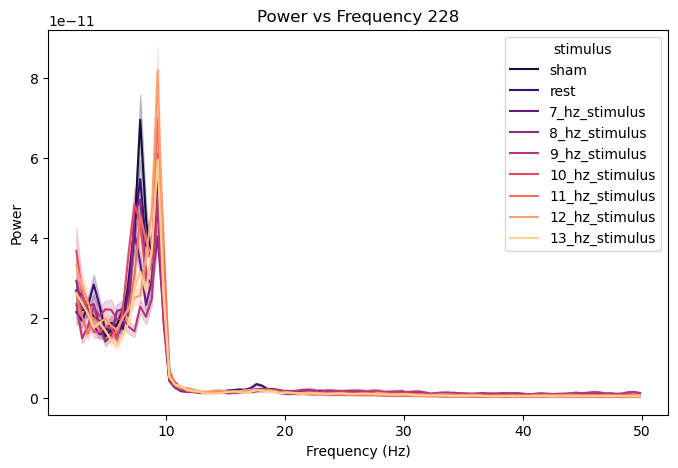

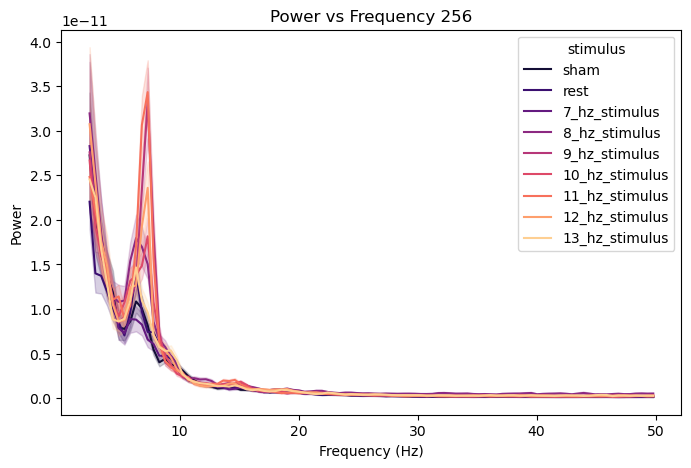

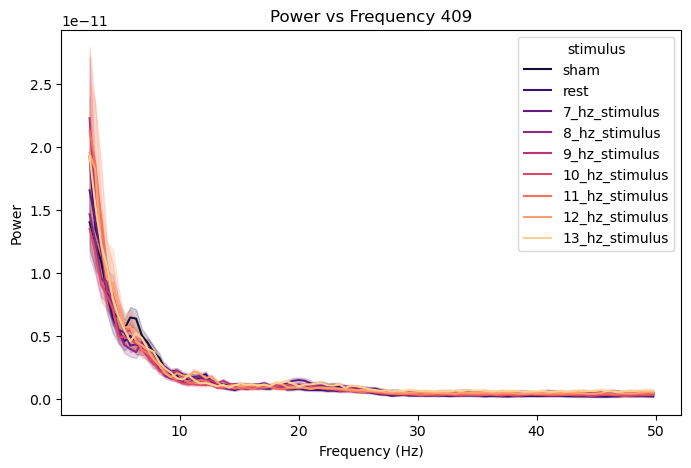

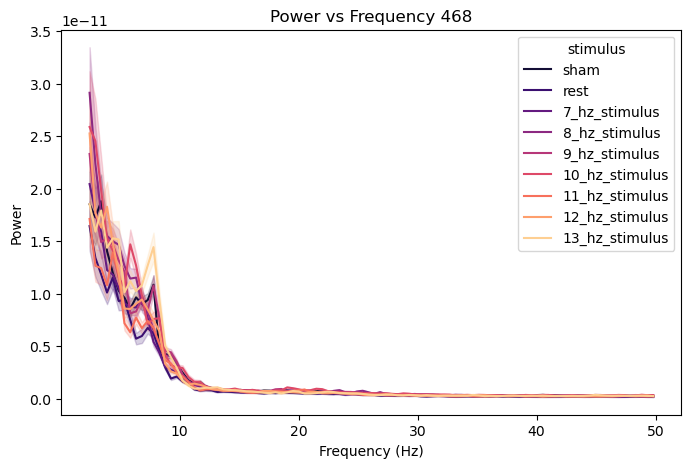

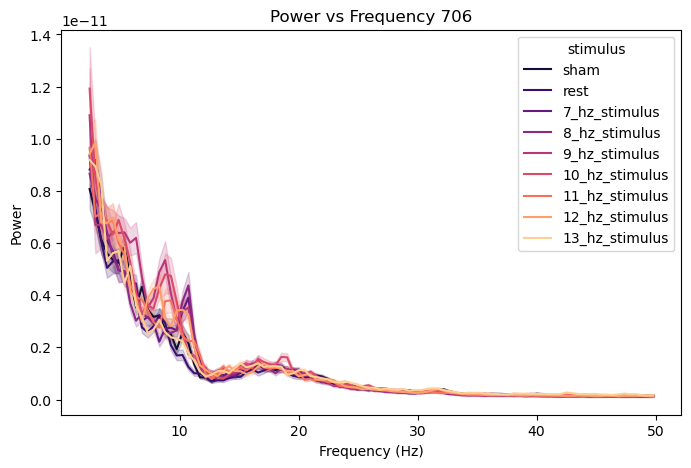

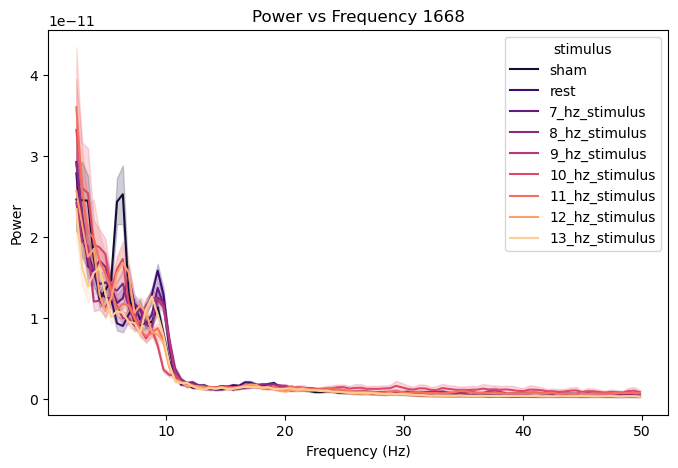

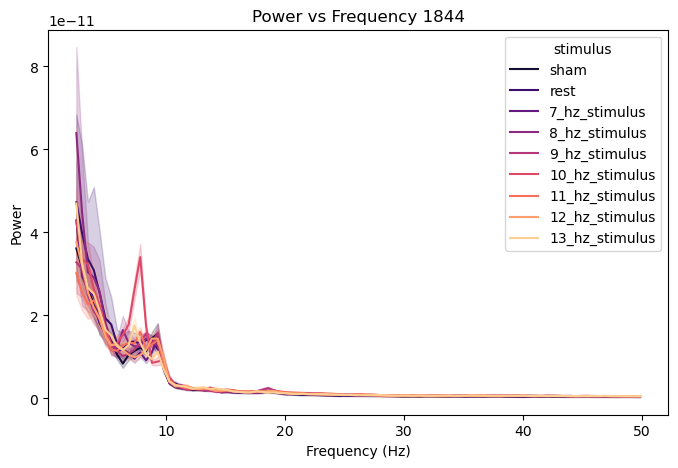

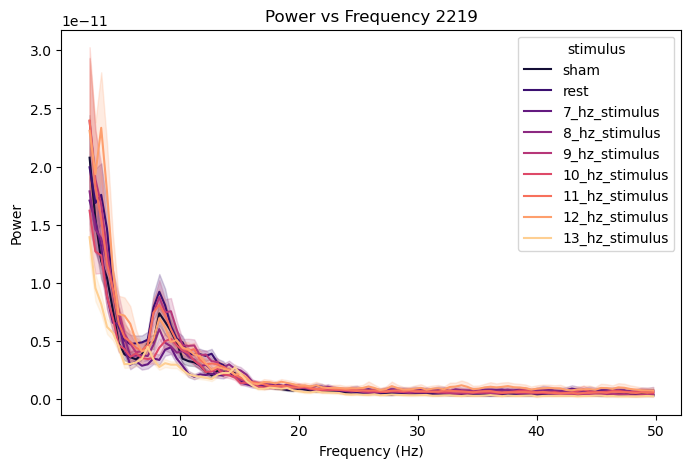

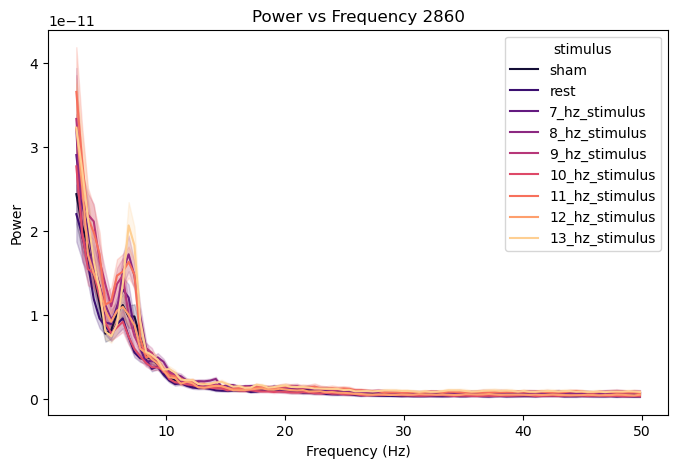

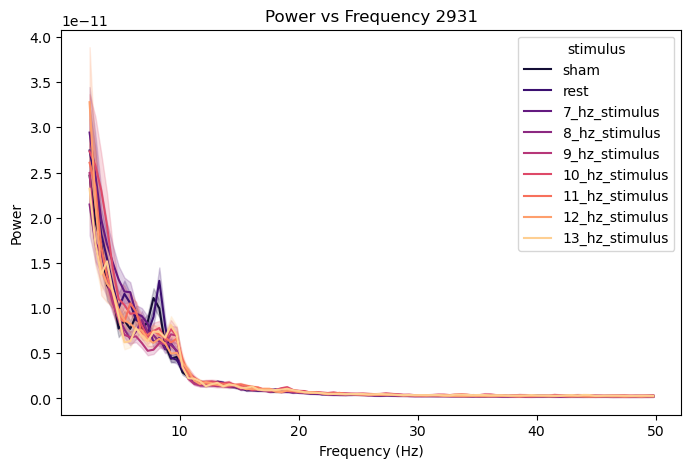

In [126]:
# Enforce specific order for plotting sitmuli 
hue_order = ['sham', 'rest','7_hz_stimulus', '8_hz_stimulus','9_hz_stimulus',
             '10_hz_stimulus', '11_hz_stimulus', '12_hz_stimulus', '13_hz_stimulus',]


# Loop through eegid
for cur_eegid in df_psd['eegid'].unique():
    
    
    # Select frequency and subject
    df_forplot = df_psd.query('frequency < 50 and eegid == @cur_eegid')
    
    # Line plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_forplot,    
        x='frequency',
        y='power',
        hue='stimulus',
        
        hue_order=hue_order,
        palette="magma"
    )
    
    # Title and labels
    plt.title(f'Power vs Frequency {cur_eegid}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    
    # Show the plot
    plt.show()



In [106]:
psds.shape

(128, 108)

In [ ]:
# parameters for fitting FOOOF 
peak_width_limits = [1, 18] # 1-18 Hz peak width
max_n_peaks = 7             # maximum of 7 peaks
min_peak_height = 0         # no minimum peak height (using peak_threshold)
peak_threshold = 2          # 2 standard deviations threshold
aperiodic_mode = 'knee'     # knee instead of fixed 

freq_range = [2, 50]

freqs
# get freq and pow values for FOOOF
freq = cur_df.freq.to_numpy()
pows = cur_df.power.to_numpy()

# interpolate notch filter if needed
#freq, pows_interp = interpolate_spectrum(freq, pows, interp_range=[55,65])

# compute fooof 
fm = FOOOF(
    peak_width_limits=peak_width_limits,
    max_n_peaks=max_n_peaks,
    min_peak_height=min_peak_height,
    peak_threshold=peak_threshold,
    aperiodic_mode=aperiodic_mode
)



In [104]:
df_psd

,eegid,group,stimulus,channel,frequency,power
0,228,uknown,10_hz_stimulus,E1,2.441406,6.997876e-11
1,228,uknown,10_hz_stimulus,E1,2.929688,3.904430e-11
2,228,uknown,10_hz_stimulus,E1,3.417969,3.087572e-11
3,228,uknown,10_hz_stimulus,E1,3.906250,2.531502e-11
4,228,uknown,10_hz_stimulus,E1,4.394531,2.194913e-11
...,...,...,...,...,...,...
13819,2931,uknown,sham,E128,52.734375,4.985109e-13
13820,2931,uknown,sham,E128,53.222656,5.808330e-13
13821,2931,uknown,sham,E128,53.710938,5.283388e-13
13822,2931,uknown,sham,E128,54.199219,4.649934e-13


# FOOOF Group

In [ ]:
# parameters for fitting FOOOF 
peak_width_limits = [1, 18] # 1-18 Hz peak width
max_n_peaks = 7             # maximum of 7 peaks
min_peak_height = 0         # no minimum peak height (using peak_threshold)
peak_threshold = 2          # 2 standard deviations threshold
aperiodic_mode = 'knee'     # knee instead of fixed 

freq_range = [2, 50]

# goodness of fit 
df_gof = group_list.copy()


list_of_result_dfs = []

# loop through eegs 
for eegid_i, cur_eegid in enumerate(group_list.eegid):
    for cur_region in region_list:
                    
        # select susbset of df, current subject and region
        cur_df = df_forFOOOF[(df_forFOOOF['eegid'] == cur_eegid) & (df_forFOOOF['region'] == cur_region)]

        # get freq and pow values for FOOOF
        freq = cur_df.freq.to_numpy()
        pows = cur_df.power.to_numpy()

        # interpolate notch filter if needed
        #freq, pows_interp = interpolate_spectrum(freq, pows, interp_range=[55,65])

        # compute fooof 
        fm = FOOOF(
            peak_width_limits=peak_width_limits,
            max_n_peaks=max_n_peaks,
            min_peak_height=min_peak_height,
            peak_threshold=peak_threshold,
            aperiodic_mode=aperiodic_mode
        )

        fm.fit(freq, pows)



        cur_df = pd.DataFrame({
            'freq' : freq, 
            'power_spec' : fm.power_spectrum,
            'aperiodic_spec' : fm._ap_fit, 
            'periodic_spec' : fm._spectrum_flat,
            'modeled_periodic' : fm._peak_fit
        })

        cur_df['eegid'] = cur_eegid
        cur_df['group'] = group_list.loc[eegid_i, 'group']
        cur_df['region'] = cur_region


        list_of_result_dfs.append(cur_df)

# join result lists together 
df_fooof = pd.concat(list_of_result_dfs)

df_fooof = df_fooof[['eegid', 'group', 'region', 'freq', 'power_spec', 'aperiodic_spec', 'periodic_spec', 'modeled_periodic']]

df_fooof

In [ ]:
# copy spec 
spec = copy.copy(result_arr_region)

# check shape of input 
print(spec.shape)
print(freqs.shape)

In [ ]:

# parameters for fitting fooof
peak_width_limits = [1, 18]     # 1-18 Hz peak width
max_n_peaks = 7                 # maximum of 7 peaks
min_peak_height = 0             # no minimum peak height (using peak_threshold)
peak_threshold = 2              # 2 standard deviations threshold
aperiodic_mode = 'knee'         # knee instead of fixed 


# set parameters for fooof group 
fg = FOOOFGroup(
    peak_width_limits=peak_width_limits,
    max_n_peaks=max_n_peaks,
    min_peak_height=min_peak_height,
    peak_threshold=peak_threshold,
    aperiodic_mode=aperiodic_mode
)

# fit fooof group
fgs = fit_fooof_3d(fg, freqs, spec)


# Get power spectrum df 

In [ ]:
# list of regions
region_list = list(channel_atlas.keys())

# list of result dfs to join later 
result_list_spec = []

# loop through subjects (first dimension of fgs)
for subject_i in range(len(fgs)):

    # get eegid and group of current subject
    cur_eegid = df_filelist.loc[subject_i, 'eegid']
    cur_group = df_filelist.loc[subject_i, 'group']

    cur_fg = fgs[subject_i]

    for region_i in range(len(cur_fg)):

        cur_region = region_list[region_i]
        
        cur_fm = cur_fg.get_fooof(region_i)

        cur_df = pd.DataFrame({
            'freq' : freqs,
            'power_spec' : cur_fm.power_spectrum,
            'aperiodic_spec' : cur_fm._ap_fit,
            'periodic_spec' : cur_fm.power_spectrum - cur_fm._ap_fit, #cur_fm._spectrum_flat
            'modeled_periodic' : cur_fm._peak_fit
        })

        # set region, group, eegid of current subject
        cur_df['eegid'] = cur_eegid
        cur_df['group'] = cur_group
        cur_df['region'] = cur_region

        result_list_spec.append(cur_df)


# join dfs and reorder variables
df_spec = pd.concat(result_list_spec)
df_spec = df_spec[['eegid', 'group', 'region', 'freq', 'power_spec', 'aperiodic_spec', 'periodic_spec', 'modeled_periodic']]

# display result table 
df_spec


In [ ]:
sns.lineplot(
    data=df_spec,
    x='freq',
    y='power_spec'
)

# get peaks 

In [ ]:
# wilkinson band defs
band_defs = Bands({
    'theta':[4, 6.5],
    'theta_alpha':[4, 12],  
    'low_beta':[12, 20],
    'high_beta':[20, 30]
})

# custom band defs
band_defs = Bands({
    'theta' : [4, 8], 
    'sigma' : [10, 15],
    'gamma1' : [30, 55]
})


# band_defs = Bands({
#     'alpha':[6, 12]
# })


In [ ]:
band_defs[curband]

In [ ]:
# list of regions
region_list = list(channel_atlas.keys())

# list of result dfs to join later 
result_dict_list_peaks = []

# loop through subjects (first dimension of fgs)
for subject_i in range(len(fgs)):

    # get eegid and group of current subject
    cur_eegid = df_filelist.loc[subject_i, 'eegid']
    cur_group = df_filelist.loc[subject_i, 'group']

    cur_fg = fgs[subject_i]

    for region_i in range(len(cur_fg)):

        cur_region = region_list[region_i]
        cur_fm = cur_fg.get_fooof(region_i)


        for curband in band_defs.labels:

            band_peaks_all = get_band_peak_fm(cur_fm, band_defs[curband], select_highest = False)

            if(band_peaks_all.ndim == 1):
                if(np.isnan(band_peaks_all[0])):
                    n_peaks = 0 #np.nan
                    peak_pow = np.nan
                    peak_freq = np.nan
                else:
                    n_peaks = 1
                    peak_pow = band_peaks_all[1]
                    peak_freq = band_peaks_all[0]

            else:
                
                n_peaks = band_peaks_all.shape[0]
                
                # only pick max peak
                band_peaks_all = get_band_peak_fm(cur_fm, band_defs[curband], select_highest = True)
                peak_pow = band_peaks_all[1] 
                peak_freq = band_peaks_all[0]


            avg_pow = get_bandpower_from_spec(
                freqs=cur_fm.freqs,
                psds=cur_fm.power_spectrum - cur_fm._ap_fit,
                freq_range=band_defs[curband],
                method='average_do_not_use_this'
            )
            band_pow = get_bandpower_from_spec(
                freqs=cur_fm.freqs,
                psds=cur_fm.power_spectrum - cur_fm._ap_fit,
                freq_range=band_defs[curband],
                method='trapz'
            )


            cur_result_dict = {
                'eegid' : cur_eegid, 
                'group' : cur_group,
                'region' : cur_region,
                'freq_band' : curband, 
                'n_peaks' : n_peaks,
                'peak_freq' : peak_freq,
                'peak_pow' : peak_pow,
                'band_pow' : band_pow,
                'avg_pow' : avg_pow,
            }


            result_dict_list_peaks.append(cur_result_dict)


# join dfs and reorder variables
df_spec_peaks = pd.DataFrame(result_dict_list_peaks)
#df_spec = df_spec[['eegid', 'group', 'region', 'freq', 'power_spec', 'aperiodic_spec', 'periodic_spec', 'modeled_periodic']]

# display result table 
df_spec_peaks


In [ ]:
# save as CSV 
df_spec_peaks.to_csv("./results/eden_fooof_fooofPeaks_myBandDefs.csv")

df_spec.to_csv("./results/eden_fooof_power_spec.csv")

# testing

In [ ]:
# power spec


# power spec
plt.figure(figsize=(8,5))


sns.lineplot(
    data=df_spec.query('region == "frontal"'),
    x='freq',
    y='modeled_periodic',
    hue='group',

    estimator=None,
    units='eegid',

    size=0.1,
    alpha=0.5
) 

sns.scatterplot(
    data = df_spec_peaks.query('region == "frontal"'), 
    x='peak_freq', 
    y='peak_pow',
    hue='freq_band',
    palette='brg'
)


plt.legend(loc='upper right')
plt.title("Modeled FOOOF Peaks")
plt.xlabel("Frequency (Hz)")

plt.show()

In [ ]:
tmp = df_spec_peaks.query('region == "central" and freq_band == "alpha"')

pd.crosstab(tmp['group'], tmp['n_peaks'])

In [ ]:
tmp = df_spec_peaks.copy()



tmp.loc[tmp['peak_pow'].isna(), 'peak_pow'] = 0


sns.boxplot(
    data=tmp,
    x='group', 
    hue='group', 
    y='peak_pow',
    showfliers=False
)

sns.stripplot(
    data=tmp,
    x='group', 
    y='peak_pow',
    color='black'
)

In [ ]:
df_forplot = df_spec_peaks.copy().query('region=="frontal"')

df_forplot['peak_freq_cleaned'] = df_forplot['peak_freq']

df_forplot['peak_freq_cleaned'].fillna(0, inplace=True)


# Create the ribbon plot with violin plot
sns.violinplot(
    data=df_forplot,
    x='group', 
    y='peak_freq_cleaned',
    inner=None,  # Do not show inner bars or points
    hue='group', 
    bw=0.2
)

# Overlay with swarm plot for individual data points
sns.swarmplot(
    data=df_forplot,
    x='group',
    y='peak_freq_cleaned',
    color='black'  # Color of the swarm plot points
)

plt.xlabel("Group")
plt.ylabel("Alpha peak frequency (Hz)")

plt.title("Alpha peak frequency, frontal, fooof")
plt.show()

In [ ]:
df_forplot

In [ ]:

plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_spec[df_spec['region']=='frontal'],
    x='freq',
    y='periodic_spec',
    hue='group',

    estimator=None,
    units='eegid',

    size=0.1,
    alpha=0.5
) 

plt.axvline(x=4, linestyle='--', color='red')
plt.axvline(x=12, linestyle='--', color='red')

In [ ]:

plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_spec[df_spec['region']=='frontal'],
    x='freq',
    y='power_spec',
    hue='group',

    estimator=None,
    units='eegid',

    size=0.1,
    alpha=0.5
) 